# Capsule Networks

To understand intuition behind capsule networks follow these blogs: 
1. [Capsule Networks](https://theailearner.com/2019/01/21/capsule-networks/)
2. [Implementing Capsule Network in Keras](https://theailearner.com/2019/01/21/implementing-capsule-network-in-keras/)

## Introduction

A capsule is a group of neurons which uses vectors to represent an object or object part. Length of a vector represents presence of an object and orientation of vector represents its pose(size, position, orientation, etc). Group of these capsules forms a capsule layer and then these layers lead to form a capsule network.

We can break the implementation of capsule network into following steps:

1. Initial convolutional layer
2. Primary capsule layer
3. Digit capsule layer
4. Decoder network
5. Loss Functions
6. Training and testing of model

### Imports

In [5]:
import keras
from keras.models import Model
from keras.layers import Conv2D, Dense, Input, Reshape, Lambda, Layer, Flatten
from keras.layers import LeakyReLU, BatchNormalization, MaxPool2D
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import initializers
from keras.utils import to_categorical
from keras.layers.core import Activation
import pandas as pd
from keras.optimizers import Nadam


### Load Kaggle Face Data

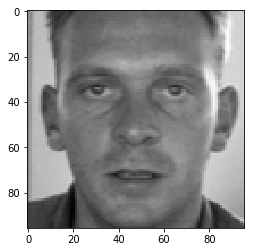

In [3]:
# download training and test data from mnist and reshape it

train_file = '../input/training/training.csv'
test_file = '../input/test/test.csv'
train_data = pd.read_csv(train_file)  
test_data = pd.read_csv(test_file)
train_data.isnull().any().value_counts()
columns_nan = train_data.columns[train_data.isna().any()].tolist()
train_data[columns_nan] = train_data[columns_nan].fillna(value=train_data[columns_nan].mean())

x_train = []
for i in range(train_data.shape[0]):
    image = train_data['Image'][i].split(' ')
    image = ['0' if x == '' else x for x in image]
    x_train.append(image)
    
x_train = np.array(x_train,dtype = 'float')
x_train = x_train/255.0
x_train = x_train.reshape(-1,96,96,1)
plt.imshow(x_train[2].reshape(96,96),cmap='gray')
plt.show()

y_train = []
for i in range(train_data.shape[0]):
    label = train_data.iloc[i,0:30]
    y_train.append(label)
    
y_train = np.array(y_train,dtype = 'float')

In [23]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
print(x_train.shape, x_test.shape)

(5639, 96, 96, 1) (1410, 96, 96, 1)


### Initial Convolution Layer

Initially we will use a convolution layer to detect low level features of an image.  Input size of image is 96x96, after applying this layer output size will be 6x6x256.

In [6]:
input_shape = Input(shape=(96,96,1))  # size of input image is 96*96
 
# a convolution layer output shape = 20*20*256
#conv1 = Conv2D(256, (9,9), activation = 'relu', padding = 'valid')(input_shape)
x = Conv2D(32, (3,3), padding='same', use_bias=False)(input_shape)
x = LeakyReLU(alpha = 0.1)(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3,3), padding='same', use_bias=False)(x)
x = LeakyReLU(alpha = 0.1)(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Conv2D(96, (3,3), padding='same', use_bias=False)(x)
x = LeakyReLU(alpha = 0.1)(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Conv2D(128, (3,3),padding='same', use_bias=False)(x)
x = LeakyReLU(alpha = 0.1)(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Conv2D(256, (3,3),padding='same',use_bias=False)(x)
x = LeakyReLU(alpha = 0.1)(x)
conv1 = BatchNormalization()(x)

Instructions for updating:
Colocations handled automatically by placer.


### Primary Capsule Layer

The output is then reshaped into 8-dimensional vector. So shape will be 6x6x32 capsules each of which will be 8-dimensional. Then it will pass through a non-linear function(squash) so that length of output vector can be maintained between 0 and 1.

In [7]:
# convolution layer with stride 2 and 256 filters of size 9*9
#conv2 = Conv2D(256, (9,9), strides = 2, padding = 'valid')(conv1)
 
# reshape into 1152 capsules of 8 dimensional vectors
reshaped = Reshape((6*6*32,8))(conv1)
 
def squash(inputs):
    # take norm of input vectors
    squared_norm = K.sum(K.square(inputs), axis = -1, keepdims = True)
 
    # use the formula for non-linear function to return squashed output
    return ((squared_norm/(1+squared_norm))/(K.sqrt(squared_norm+K.epsilon())))*inputs

# squash the reshaped output to make length of vector b/w 0 and 1
squashed_output = Lambda(squash)(reshaped)

### Digit Capsule Layer

Here we need to write a custom layer in keras. It will take 1152x8 as its input and produces output of size 30x16, where 30 capsules each represents an output class with 16 dimensional vector. Then each of these 30 capsules are converted into single value to predict the output class using a lambda layer.

In [9]:
class DigitCapsuleLayer(Layer):
    # creating a layer class in keras
    def __init__(self, **kwargs):
        super(DigitCapsuleLayer, self).__init__(**kwargs)
        self.kernel_initializer = initializers.get('glorot_uniform')
    
    def build(self, input_shape): 
        # initialize weight matrix for each capsule in lower layer
        self.W = self.add_weight(shape = [30, 6*6*32, 16, 8], initializer = self.kernel_initializer, name = 'weights')
        self.built = True
    
    def call(self, inputs):
        inputs = K.expand_dims(inputs, 1)
        inputs = K.tile(inputs, [1, 30, 1, 1])
        # matrix multiplication b/w previous layer output and weight matrix
        inputs = K.map_fn(lambda x: K.batch_dot(x, self.W, [2, 3]), elems=inputs)
        b = tf.zeros(shape = [K.shape(inputs)[0], 30, 6*6*32])
        
# routing algorithm with updating coupling coefficient c, using scalar product b/w input capsule and output capsule
        for i in range(3):
            c = tf.nn.softmax(b, dim=1)
            s = K.batch_dot(c, inputs, [2, 2])
            v = squash(s)
            b = b + K.batch_dot(v, inputs, [2,3])
            
        return v 
    def compute_output_shape(self, input_shape):
        return tuple([None, 30, 16])
    
    
    
def output_layer(inputs):
    return K.sqrt(K.sum(K.square(inputs), -1) + K.epsilon())
 
digit_caps = DigitCapsuleLayer()(squashed_output)
outputs = Lambda(output_layer)(digit_caps)

Instructions for updating:
dim is deprecated, use axis instead


### Decoder Network

To further boost the pose parameters learned by the digit capsule layer, we can add decoder network to reconstruct the input image. In this part, decoder network will be fed with an input of size 30x16 (digit capsule layer output) and will reconstruct back the original image of size 96x96. 
During training time input to the decoder is the output from digit capsule layer which is masked with original labels. It means that other vectors except the vector corresponding to correct label will be multiplied with zero. So that decoder can only be trained with correct digit capsule. In test time input to decoder will be the same output from digit capsule layer but masked with highest length vector in that layer. Lets see the code.

In [10]:
def mask(outputs):
 
    if type(outputs) != list:  # mask at test time
        norm_outputs = K.sqrt(K.sum(K.square(outputs), -1) + K.epsilon())
        y  = K.one_hot(indices=K.argmax(norm_outputs, 1), num_classes = 30)
        y = Reshape((30,1))(y)
        return Flatten()(y*outputs)
 
    else:    # mask at train time
        y = Reshape((30,1))(outputs[1])
        masked_output = y*outputs[0]
        return Flatten()(masked_output)
    
inputs = Input(shape = (30,))
masked = Lambda(mask)([digit_caps, inputs])
masked_for_test = Lambda(mask)(digit_caps)
 
decoded_inputs = Input(shape = (16*30,))
dense1 = Dense(2048, activation = 'relu')(decoded_inputs)
dense2 = Dense(8192, activation = 'relu')(dense1)
decoded_outputs = Dense(9216, activation = 'sigmoid')(dense2)
decoded_outputs = Reshape((96,96,1))(decoded_outputs)

### Loss Functions

Now define a probabilistic loss function used for classifying digits image.

In [27]:

def loss_fn(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)
    #L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + 0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))
 
    #return K.mean(K.sum(L, 1))
    
# Custom RMSE metric

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))    

### Training of model

In [26]:
decoder = Model(decoded_inputs, decoded_outputs)
model = Model([input_shape,inputs],[outputs,decoder(masked)])
test_model = Model(input_shape,[outputs,decoder(masked_for_test)])
#model = Model(input_shape, outputs) 

 

Train on 5639 samples, validate on 1410 samples
Epoch 1/10
4096/5639 [====================>.........] - ETA: 56s - loss: 2539.3232 - lambda_2_loss: 2539.3232 - model_7_loss: 0.0671 - lambda_2_rmse: 50.3813 - model_7_rmse: 0.2074 

KeyboardInterrupt: 

In [22]:


# Use Nadam optimizer with variable learning rate
optimizer = Nadam(lr=0.00001,
                  beta_1=0.9,
                  beta_2=0.999,
                  epsilon=1e-08,
                  schedule_decay=0.004)

# Loss: MSE and Metric = RMSE
batch_size = 128
epochs = 10
model.compile(optimizer=optimizer, #keras.optimizers.Adam(lr=0.001),
              loss=[loss_fn,'mse'],
              loss_weights = [1. ,0.0005],
              metrics=[rmse])

history = model.fit([x_train, y_train],
                    [y_train, x_train], 
                    batch_size = batch_size, 
                    epochs = epochs, 
                    validation_data = ([x_test, y_test],[y_test,x_test]))


#Callback to save the best model
#saveBase_Model = CNN_ModelCheckpoint(model, model_dir+"base_model.h5")

#define callback functions
#callbacks = [#EarlyStopping(monitor='val_rmse', patience=3, verbose=2),
            #saveBase_Model]


Instructions for updating:
Use tf.cast instead.
Train on 5639 samples, validate on 1410 samples
Epoch 1/10
5639/5639 [==============================] - 171s 30ms/step - loss: 2625.1038 - rmse: 51.2240 - val_loss: 2637.5860 - val_rmse: 51.3534
Epoch 2/10
5639/5639 [==============================] - 155s 27ms/step - loss: 2624.4949 - rmse: 51.2181 - val_loss: 2636.3479 - val_rmse: 51.3413
Epoch 3/10
3072/5639 [===============>..............] - ETA: 1:04 - loss: 2622.6920 - rmse: 51.2016

KeyboardInterrupt: 

### Predict from above trained model

In [13]:
label_predicted, image_predicted = model.predict([x_test, y_test])

### Testing of model

In [24]:
del model